In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from transformers import BertTokenizer, BertModel
from imblearn.over_sampling import SMOTE
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [18]:
# Load the cleaned data
df = pd.read_csv('../Data-Preprocessing/cleaned_data.csv')
text_column = 'tweet'

# Ensure the text column is of string type
df[text_column] = df[text_column].astype(str)

In [19]:
# Split the data into features (X) and labels (y)
X = df[text_column]
y = df['class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
# Tokenize and encode the data
def encode_data(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [21]:
X_train_ids, X_train_masks = encode_data(X_train, tokenizer)
X_test_ids, X_test_masks = encode_data(X_test, tokenizer)

# Load the BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to get embeddings from BERT in batches
def get_embeddings(input_ids, attention_masks, batch_size=32):
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, sampler=SequentialSampler(dataset), batch_size=batch_size)

    embeddings = []

    for batch in dataloader:
        batch_input_ids, batch_attention_masks = batch
        with torch.no_grad():
            outputs = bert_model(batch_input_ids, attention_mask=batch_attention_masks)
            batch_embeddings = outputs[0][:, 0, :].numpy()
            embeddings.append(batch_embeddings)

    embeddings = np.vstack(embeddings)
    return embeddings

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
X_train_embeddings = get_embeddings(X_train_ids, X_train_masks)
X_test_embeddings = get_embeddings(X_test_ids, X_test_masks)

print("Shape of BERT embeddings for training data:", X_train_embeddings.shape)
print("Shape of BERT embeddings for test data:", X_test_embeddings.shape)

Shape of BERT embeddings for training data: (19812, 768)
Shape of BERT embeddings for test data: (4954, 768)


In [23]:
# Apply SMOTE to handle data imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_embeddings, y_train)
print("After SMOTE, the number of samples in each class:")
print(y_train_smote.value_counts())

After SMOTE, the number of samples in each class:
class
1    15384
0    15384
2    15384
Name: count, dtype: int64


In [24]:
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Hyperparameter tuning for Logistic Regression with SMOTE
grid_lr_smote = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=3, n_jobs=-1)
grid_lr_smote.fit(X_train_smote, y_train_smote)
best_lr_smote = grid_lr_smote.best_estimator_
print("Best Logistic Regression Parameters with SMOTE:", grid_lr_smote.best_params_)
print("Best Logistic Regression Score with SMOTE:", grid_lr_smote.best_score_)

Best Logistic Regression Parameters with SMOTE: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Logistic Regression Score with SMOTE: 0.8321416189980934


In [25]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Hyperparameter tuning for SVM with SMOTE
grid_svm_smote = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, n_jobs=-1)
grid_svm_smote.fit(X_train_smote, y_train_smote)
best_svm_smote = grid_svm_smote.best_estimator_
print("Best SVM Parameters with SMOTE:", grid_svm_smote.best_params_)
print("Best SVM Score with SMOTE:", grid_svm_smote.best_score_)

Best SVM Parameters with SMOTE: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best SVM Score with SMOTE: 0.9155182873981627


In [26]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Hyperparameter tuning for Random Forest with SMOTE
grid_rf_smote = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
grid_rf_smote.fit(X_train_smote, y_train_smote)
best_rf_smote = grid_rf_smote.best_estimator_
print("Best Random Forest Parameters with SMOTE:", grid_rf_smote.best_params_)
print("Best Random Forest Score with SMOTE:", grid_rf_smote.best_score_)

Best Random Forest Parameters with SMOTE: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Score with SMOTE: 0.9460045068469406


Model: Logistic Regression SMOTE
Accuracy: 0.7509083568833266
Confusion Matrix:
 [[ 152   77   53]
 [ 524 2869  405]
 [  87   88  699]]


Model: SVM SMOTE
Accuracy: 0.8286233346790473
Confusion Matrix:
 [[  97  140   45]
 [ 191 3342  265]
 [  49  159  666]]


Model: Random Forest SMOTE
Accuracy: 0.8296326201049656
Confusion Matrix:
 [[  36  205   41]
 [  30 3477  291]
 [   2  275  597]]


Best Model: Random Forest SMOTE
Best Accuracy: 0.8296326201049656


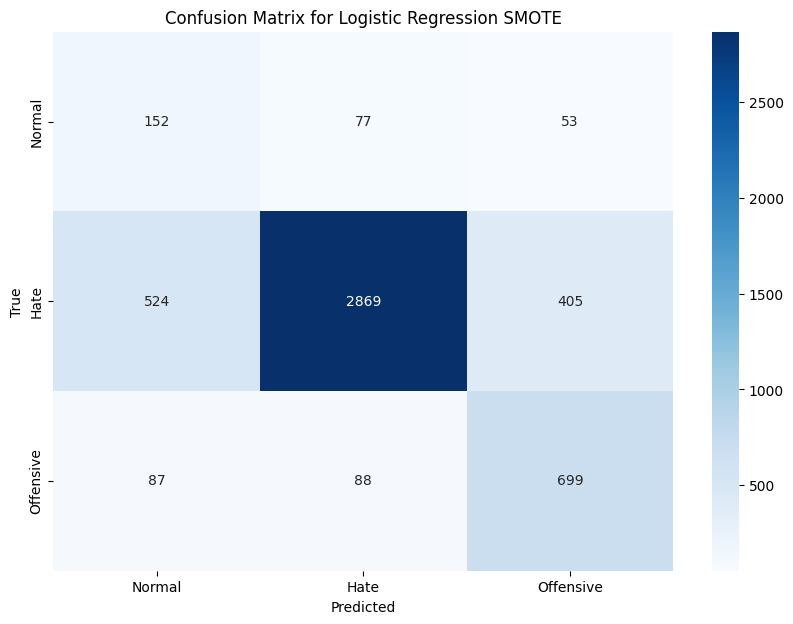

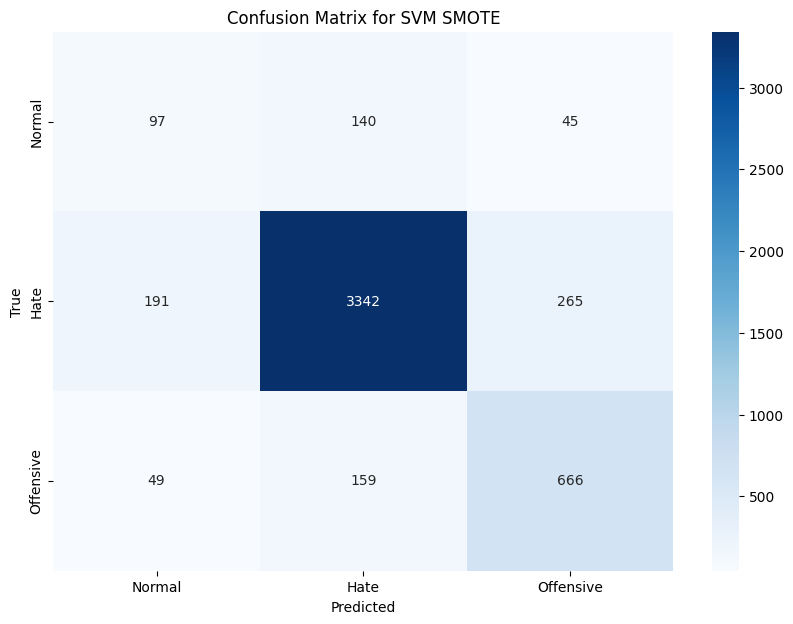

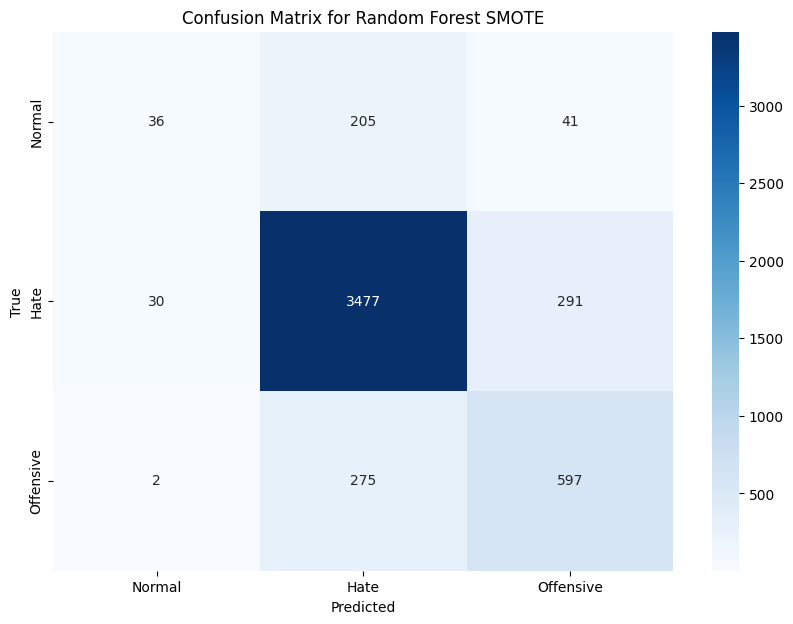

Best model saved as best_random_forest_smote.pkl.


In [27]:
models = {
    'Logistic Regression SMOTE': best_lr_smote,
    'SVM SMOTE': best_svm_smote,
    'Random Forest SMOTE': best_rf_smote
}

best_model = None
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    y_pred = model.predict(X_test_embeddings)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {name}")
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy}")

for name, model in models.items():
    y_pred = model.predict(X_test_embeddings)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Hate', 'Offensive'], yticklabels=['Normal', 'Hate', 'Offensive'])
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

model_filename = f"best_{best_model_name.replace(' ', '_').lower()}.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model saved as {model_filename}.")